# Emotional Speech Recognition
This notebook will be an audio classification problem and solved with Audio Feature extraction and augmentation, Machine Learning and Deep Learning. 

https://www.kaggle.com/dejolilandry/asvpesdspeech-nonspeech-emotional-utterances

In [1]:
import numpy as np 
import pandas as pd
import os 
import math
import torch 
import torchaudio 
import torch.nn as nn 
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt 
#%matplotlib_inline
import seaborn as sns
import librosa 
import librosa.display

import IPython.display as ipd


# custom modules 
from MyDataClasses import ASVPDataset
import torch_functions

In [26]:
ASVP_dir = '/Users/stephen/Desktop/Speech_Recognition/Data/ASVP-ESD_UPDATE/Audio/'
ASVP_metadata = pd.read_csv('/Users/stephen/Desktop/Speech_Recognition/Data/ASVP-ESD_UPDATE/asvp_metadata.csv', index_col=0)
ASVP_metadata.head()

,Emotions,Folder,Filename,Sample_Rate,Num_Frames,Duration
0,neutral,actor_16,/03-01-02-01-02-16-03-03-01.wav,16000,44305,2.769062
1,angry,actor_16,/03-01-05-02-07-16-03-03-01.wav,16000,96922,6.057625
2,neutral,actor_16,/03-01-02-01-13-16-03-03-01.wav,16000,58396,3.649750
3,neutral,actor_16,/03-01-02-01-05-16-03-03-01.wav,16000,13794,0.862125
4,angry,actor_16,/03-01-05-02-06-16-03-03-01.wav,16000,49738,3.108625


In [30]:
print(f'The length of the dataset is: {len(ASVP_metadata)}')

The length of the dataset is: 3946


In [27]:
ASVP_metadata.describe()

,Sample_Rate,Num_Frames,Duration
count,3946.0,3946.000000,3946.000000
mean,16000.0,100414.223517,6.275889
std,0.0,57767.822831,3.610489
min,16000.0,6069.000000,0.379312
25%,16000.0,51052.250000,3.190766
50%,16000.0,96000.000000,6.000000
75%,16000.0,146401.000000,9.150063
max,16000.0,489013.000000,30.563312


# Deciding how long all the files will be 
inorder for the CNN to take in an audio dataset all the audio files must be the same length. From the analysis we did in EDA we can see the lengths vary from 3.7 seconds to over 330 seconds.

In [36]:
# how many are less than 20 seconds 
over_20_sec = len(ASVP_metadata) - len(ASVP_metadata[ASVP_metadata['Duration'] <= 20])
print(f"There are {over_20_sec} rows over 20 seconds")

There are 17 rows over 20 seconds


Looks like we only lose 17 rows if we get ride of everything over 20 seconds. Lets see how many we lose when we cut everything over 15 seconds and 10 seconds. The shorter then length of all our audio files the less computation power we'll nee. 

In [33]:
ASVP_metadata['Duration']

0        2.769062
1        6.057625
2        3.649750
3        0.862125
4        3.108625
          ...    
3941    10.488000
3942    10.440000
3943    10.392000
3944    12.408000
3945     9.743688
Name: Duration, Length: 3946, dtype: float64

In [21]:
# Global Variables 

SAMPLE_RATE = 16000
N_FFT = int(0.025 * SAMPLE_RATE)   # 25 ms 
HOP_LENGTH = int(0.01 * SAMPLE_RATE)  # 10 ms
DURATION = 20 
N_SAMPLES = SAMPLE_RATE * DURATION 

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"



,Emotions,Folder,Filename,Sample_Rate,Num_Frames,Duration
0,neutral,actor_16,/03-01-02-01-02-16-03-03-01.wav,16000,44305,2.769062
1,angry,actor_16,/03-01-05-02-07-16-03-03-01.wav,16000,96922,6.057625
2,neutral,actor_16,/03-01-02-01-13-16-03-03-01.wav,16000,58396,3.649750
3,neutral,actor_16,/03-01-02-01-05-16-03-03-01.wav,16000,13794,0.862125
4,angry,actor_16,/03-01-05-02-06-16-03-03-01.wav,16000,49738,3.108625


In [22]:
audio_dataset = ASVPDataset(
    annotations_file=ASVP_metadata, 
    audio_dir=ASVP_dir,
    target_sample_rate=SAMPLE_RATE, 
    num_samples=N_SAMPLES,
    device=device  
)

In [23]:
len(audio_dataset)

3946

In [24]:
audio_dataset[133]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.]]), 'angry')

/Users/stephen/opt/anaconda3/envs/torch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


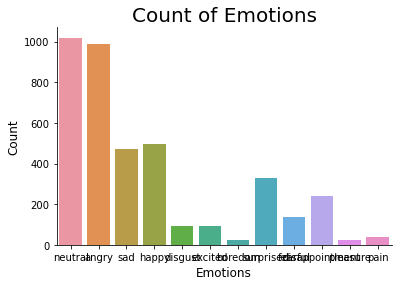

In [25]:
plt.title('Count of Emotions', size=20)
sns.countplot(ASVP_metadata.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Data Preprossing 

not that we are able to locate our data properly we'll create a custom Dataset object with Pytorch. This will make it easier to work with 

In [ ]:
# helper functions 

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

# Define a function to plot accuracy and loss

def plot_accuracy_loss(training_results): 
    plt.subplot(2, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    plt.subplot(2, 1, 2)
    plt.plot(training_results['validation_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epochs')   
    plt.show()

# Define a function to plot model parameters


In [ ]:
test_sample, test_label = emotional_speech_dataset[1000]
print(test_label, test_sample)

In [ ]:

plot_waveform(test_sample, 16000)
print_stats(test_sample)


In [ ]:
n_fft = 1024
win_length = None
hop_length = 512

# define transformation
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation
spec = spectrogram(test_sample)

print_stats(spec)
plot_spectrogram(spec[0], title='torchaudio')


# Split data into Train, Test and Validation sets 

In [ ]:
total_count = len(emotional_speech_dataset)
train_count = int(0.7 * total_count)
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count
print('Train count: ' + str(train_count))
print('validation count: ' + str(valid_count))
print('Test count: ' + str(test_count))

In [ ]:
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(emotional_speech_dataset, (train_count, valid_count, test_count))

In [ ]:
labels = sorted(list(set(r[1] for r in train_dataset)))
labels


In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]

In [ ]:
word_start = "neutral"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

In [ ]:
type(index)


In [ ]:
new_sample_rate = 16000
transform = torchaudio.transforms.Resample(orig_freq=16000, new_freq=new_sample_rate)
transformed = transform(test_sample)

In [ ]:
one_hot = torch.nn.functional.one_hot(index, 12)
one_hot

In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 64
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate_fn, num_workers=num_workers, pin_memory=pin_memory)

In [ ]:
train_loader

# Model 

In [ ]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=8, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

In [ ]:
model = M5(n_input=test_sample.shape[0], n_output=len(labels))
model.to(device)
print(model)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

# train net

In [ ]:
lost_list = []
accuracy_list = [ ]
N_test=len(test_dataset)


def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        #data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        #data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        #data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)
        accuracy = correct / N_test
        accuracy_list.append(accuracy)     

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [ ]:
log_interval = 20
n_epoch = 20

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
#transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

In [ ]:
# Plot the loss and accuracy

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(losses, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Loss', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()


# Define a function to plot accuracy and loss

def plot_accuracy_loss(training_results): 
    plt.subplot(2, 1, 1)
    plt.plot(training_results['training_loss'], 'r')
    plt.ylabel('loss')
    plt.title('training loss iterations')
    plt.subplot(2, 1, 2)
    plt.plot(training_results['validation_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epochs')   
    plt.show()

# Define a function to plot model parameters

def print_model_parameters(model):
    count = 0
    for ele in model.state_dict():
        count += 1
        if count % 2 != 0:
            print ("The following are the parameters for the layer ", count // 2 + 1)
        if ele.find("bias") != -1:
            print("The size of bias: ", model.state_dict()[ele].size())
        else:
            print("The size of weights: ", model.state_dict()[ele].size())

In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, label = train_dataset[-1]
#ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {label}. Predicted: {predict(waveform)}.")